# 旋转阻尼系数辨识 (Rotational Damping Identification)

**Objective:**
Identify the linear ($d_q$) and quadratic ($d_{q|q|}$) damping coefficients from free decay test data (or CFD dynamic mesh results).

**Equation of Motion (pure rotation assumption):**
$$ (I_{yy} - M_{\dot{q}}) \dot{q} = -(d_q + d_{q|q|}|q|)q - \underbrace{k \cdot \theta}_{\text{Small angle restoring}} $$
*Note: For large angles, restoring moment is nonlinear.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display

# Setup plotting style
plt.rcParams['font.sans-serif'] = ['SimHei'] # For Chinese support
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# System Constants
m_dry = 2.55           # [kg] Dry mass
m_water_inner = 0.21   # [kg] Water inside fairing
I_yy_dry = 0.05741     # [kg m^2] Dry moment of inertia
I_water_inner = 0.01119 # [kg m^2] Water inertia
M_q_outer = -0.115     # [kg m^2] Outer Added Mass Moment
mu_theta = 0.60        # Permeability coefficient

# Geometric & Force Parameters
L = 0.625              # [m]
rho = 1000.0           # [kg/m^3] Updated rho
x_b = 0.02535          # [m] Vertical distance from CG to CB (at theta=0)
z_b = 0                # [m]
B_mass = 2.555         # [kg] Buoyancy equivalent mass
B_force = B_mass * 9.81 # [N] Buoyancy Force

# --- Variable Structure Dynamics Correction ---
# Formula: M_q_total = M_q_outer - mu * I_water
# Formula: (I_yy_dry - M_q_total) * q_dot = ...
M_q_total = M_q_outer - mu_theta * I_water_inner
I_virtual = I_yy_dry - M_q_total

print(f"--- Variable Structure Model Parameters ---")
print(f"I_yy_dry: {I_yy_dry} kg*m^2")
print(f"Buoyancy Force (B): {B_force:.4f} N")
print(f"Correction Term (mu*I_water): {mu_theta * I_water_inner:.6f}")
print(f"M_q_total: {M_q_total:.6f}")
print(f"Effective Virtual Inertia (I_virtual): {I_virtual:.6f} kg*m^2 (USED IN CALCULATION)")

--- Variable Structure Model Parameters ---
I_yy_dry: 0.05741 kg*m^2
Buoyancy Force (B): 25.0646 N
Correction Term (mu*I_water): 0.006714
M_q_total: -0.121714
Effective Virtual Inertia (I_virtual): 0.179124 kg*m^2 (USED IN CALCULATION)


## 1. Load Data
Load the time-series data of pitch angle ($\theta$) and pitch rate ($q$).
If $q$ is not available, compute it from $\theta$.

C:\Users\zyshi\AppData\Local\Temp\ipykernel_64856\2235737454.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, on_bad_lines='skip')
C:\Users\zyshi\AppData\Local\Temp\ipykernel_64856\2235737454.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, on_bad_lines='skip')


Dataset 1 loaded: 3093 samples
Dataset 2 loaded: 3806 samples


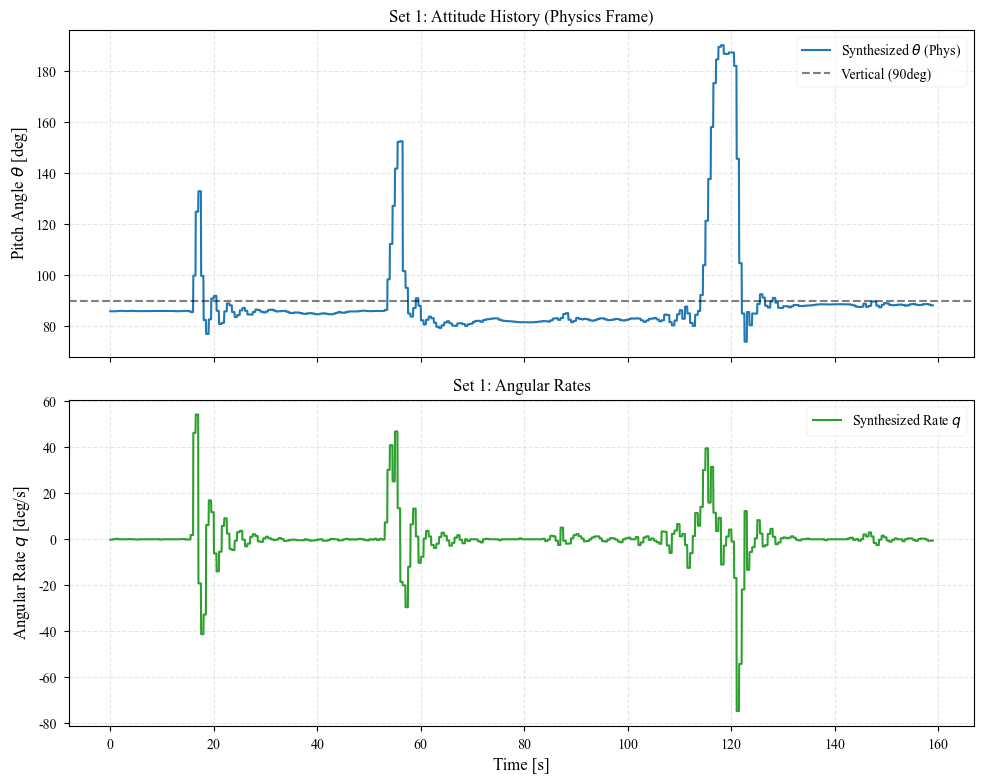

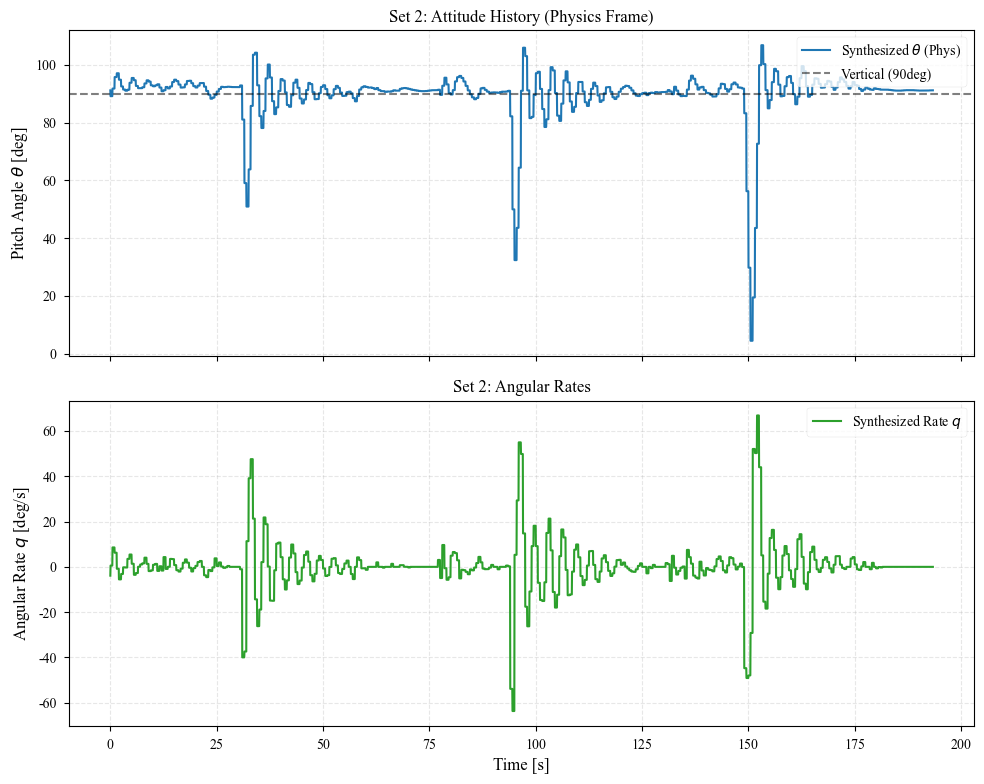

In [3]:
# Scientific Plotting Style Configuration
# Using a style close to SciencePlots / Nature
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-paper')
params = {
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (10, 6),
    'lines.linewidth': 1.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
}
mpl.rcParams.update(params)

# Load Data Function
def load_and_process_file(filepath):
    """
    Load data from txt file with columns: angleX, angleY, gyroX, gyroY, time
    Time is in ticks (1ms per tick)
    
    Synthesizes a combined Theta and Gyro (q) using PCA to handle 2D decay coupling.
    converts Laboratory Coordinates (0 deg vertical) to Physics Coordinates (90 deg vertical).
    """
    try:
        # Read whitespace separated file, handling potential non-numeric values
        df = pd.read_csv(filepath, delim_whitespace=True, on_bad_lines='skip')
        
        # Ensure numeric types (force conversion, non-numeric becomes NaN)
        numeric_cols = ['angleX', 'angleY', 'gyroX', 'gyroY', 'time']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop rows with NaN if any parsing failed
        df.dropna(inplace=True)

        if df.empty:
            print(f"Warning: File {filepath} resulted in empty dataframe after cleaning.")
            return None, None
        
        # Calculate Time (s) from ticks
        t_ticks = df['time'].values
        t_seconds = (t_ticks - t_ticks[0]) / 1000.0
        df['Time_s'] = t_seconds
        
        # --- 1. Synthesize 2D Motion into 1D (Principal Oscillation Axis) ---
        # The body oscillates in a plane that might not align with X or Y.
        # We use PCA to find the principal axis of the Angle trajectory.
        angle_data = df[['angleX', 'angleY']].values
        pca = PCA(n_components=1)
        # Project angles onto the principal component
        angle_proj = pca.fit_transform(angle_data).flatten()
        
        # Determine sign convention: Make the largest initial excursion positive (arbitrary but consistent)
        # or simply align so that the "positive" direction corresponds to the major variation
        # Here we just use the PCA output.
        
        # Project angular rates (gyro) onto the SAME principal axis component
        # The principal component vector is pca.components_[0]
        principal_axis = pca.components_[0]
        
        # Gyro projection: dot product of gyro vector [gx, gy] with principal axis [ux, uy]
        gyro_data = df[['gyroX', 'gyroY']].values
        gyro_proj = np.dot(gyro_data, principal_axis)
        
        # Store Raw Combined Data (Laboratory Frame, centered at ~0)
        df['Angle_Comb_Lab_deg'] = angle_proj
        df['Gyro_Comb_Lab_deg'] = gyro_proj
        
        # --- 2. Coordinate Transformation (Lab -> Physics) ---
        # User Req: Lab 0 deg (Vertical) -> Physics 90 deg (Vertical)
        # Formula: Theta_Phys = 90 + Theta_Lab
        # Note: We must ensure units are consistent.
        
        deg2rad = np.pi / 180.0
        
        # Physics Angles (in Degrees for plotting)
        df['Theta_Phys_deg'] = 90.0 + df['Angle_Comb_Lab_deg']
        
        # Physics Rates (deg/s) - Rates are unchanged by static offset
        df['q_Phys_deg'] = df['Gyro_Comb_Lab_deg']
        
        # Radians for Calculation
        df['Theta_Phys_rad'] = np.radians(df['Theta_Phys_deg'])
        df['q_Phys_rad'] = np.radians(df['q_Phys_deg'])
        
        # Also keep raw components in Radians if needed
        cols_to_convert = ['angleX', 'angleY', 'gyroX', 'gyroY']
        for col in cols_to_convert:
            df[f'{col}_rad'] = df[col].astype(float) * deg2rad
            
        return df, t_seconds
        
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None, None
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None

# Load both datasets
file1_path = '../dq_analysis_1.txt' # Adjust path relative to notebook location
file2_path = '../dq_analysis_2.txt'

# Try absolute path if relative fails
if not os.path.exists(file1_path):
    file1_path = 'd:/AD_v2_CFD_stage_1/dq_analysis_1.txt'
    file2_path = 'd:/AD_v2_CFD_stage_1/dq_analysis_2.txt'

df1, t1 = load_and_process_file(file1_path)
df2, t2 = load_and_process_file(file2_path)

if df1 is not None and df2 is not None:
    print(f"Dataset 1 loaded: {len(df1)} samples")
    print(f"Dataset 2 loaded: {len(df2)} samples")

    # Plotting: Two Separate Figures for Clarity
    # Figure 1: Dataset 1
    # We plot the Synthesized Physics Angle (oscillating around 90)
    fig1, (ax1_1, ax1_2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Set 1 Angles
    ax1_1.plot(df1['Time_s'], df1['Theta_Phys_deg'], color='#1f77b4', label=r'Synthesized $\theta$ (Phys)')
    ax1_1.axhline(90, color='k', linestyle='--', alpha=0.5, label='Vertical (90deg)')
    ax1_1.set_ylabel(r'Pitch Angle $\theta$ [deg]')
    ax1_1.set_title('Set 1: Attitude History (Physics Frame)')
    ax1_1.legend(loc='upper right')
    ax1_1.grid(True)

    # Set 1 Angular Rates
    ax1_2.plot(df1['Time_s'], df1['q_Phys_deg'], color='#2ca02c', label=r'Synthesized Rate $q$')
    ax1_2.set_xlabel('Time [s]')
    ax1_2.set_ylabel(r'Angular Rate $q$ [deg/s]')
    ax1_2.set_title('Set 1: Angular Rates')
    ax1_2.legend()
    ax1_2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Figure 2: Dataset 2
    fig2, (ax2_1, ax2_2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Set 2 Angles
    ax2_1.plot(df2['Time_s'], df2['Theta_Phys_deg'], color='#1f77b4', label=r'Synthesized $\theta$ (Phys)')
    ax2_1.axhline(90, color='k', linestyle='--', alpha=0.5, label='Vertical (90deg)')
    ax2_1.set_ylabel(r'Pitch Angle $\theta$ [deg]')
    ax2_1.set_title('Set 2: Attitude History (Physics Frame)')
    ax2_1.legend(loc='upper right')
    ax2_1.grid(True)

    # Set 2 Angular Rates
    ax2_2.plot(df2['Time_s'], df2['q_Phys_deg'], color='#2ca02c', label=r'Synthesized Rate $q$')
    ax2_2.set_xlabel('Time [s]')
    ax2_2.set_ylabel(r'Angular Rate $q$ [deg/s]')
    ax2_2.set_title('Set 2: Angular Rates')
    ax2_2.legend()
    ax2_2.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("Could not load one or both datasets.")

#### 1.1 选取set2作为参数辨识数据集

Data Smoothed: Resampled to 193422 points
Detected Maxima at: [  1.929  34.434  97.098 153.138]
Detected Minima at: [ 32.438  95.101 150.598]


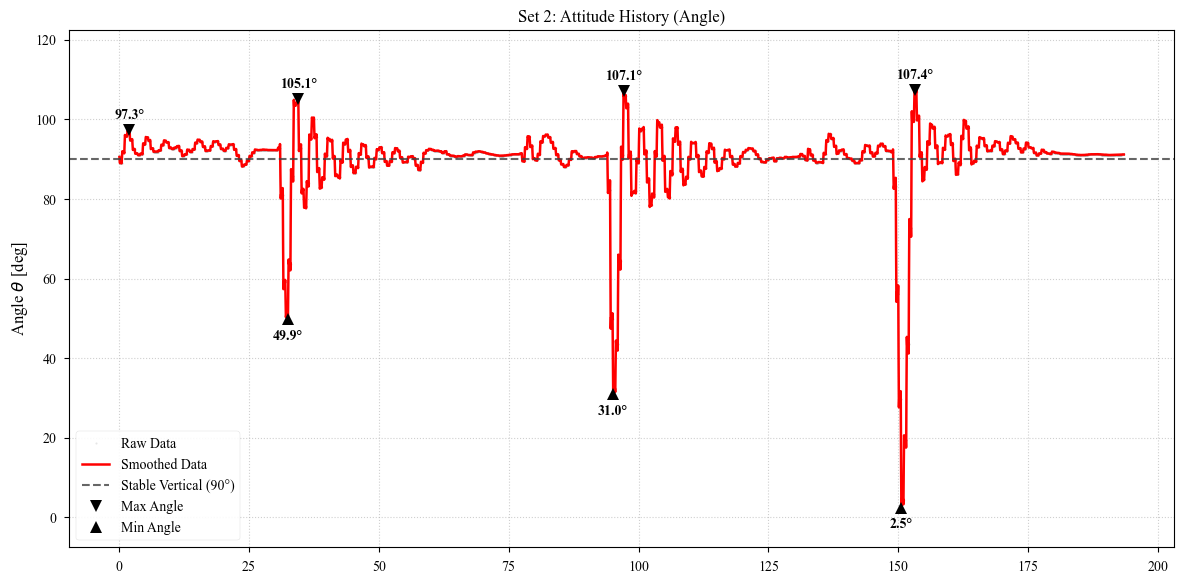

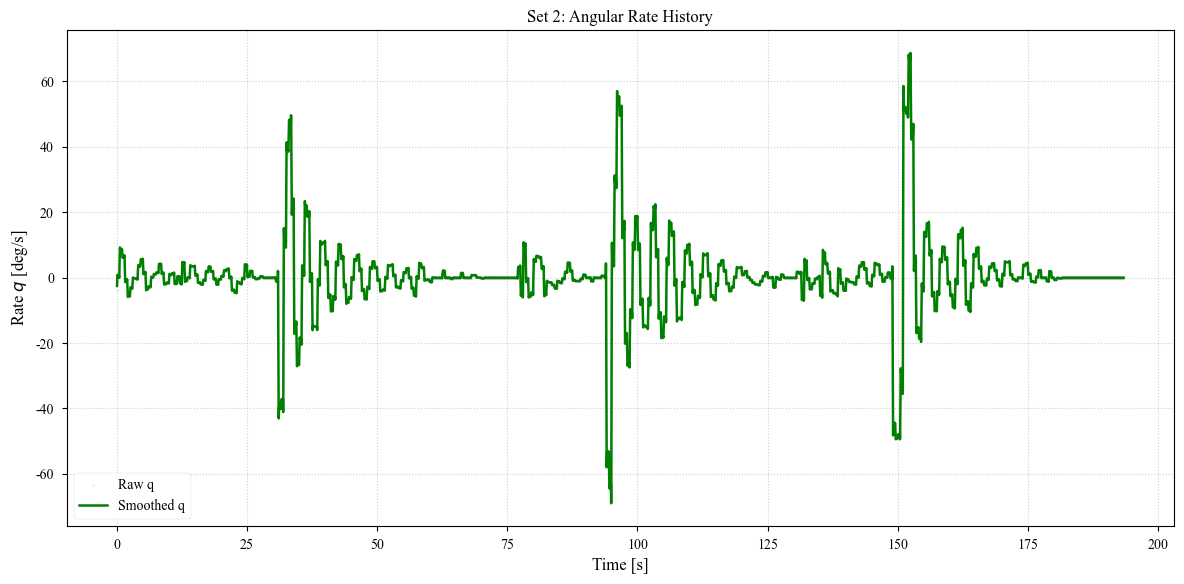

In [4]:
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d

# --- 2.1 Interpolation & Smoothing (For Set 2) ---

# Copy raw data
data_raw = df2.copy()

# A. Interpolation (Quadratic)
t_raw = data_raw['Time_s'].values
dt_uniform = 0.001 
t_uniform = np.arange(t_raw[0], t_raw[-1], dt_uniform)

f_theta = interp1d(t_raw, data_raw['Theta_Phys_deg'], kind='quadratic', fill_value="extrapolate")
f_q = interp1d(t_raw, data_raw['q_Phys_deg'], kind='quadratic', fill_value="extrapolate")

theta_interp = f_theta(t_uniform)
q_interp = f_q(t_uniform)

# B. Smoothing (Savgol)
window_len = 201 
poly_order = 2 

theta_smooth = savgol_filter(theta_interp, window_len, poly_order)
q_smooth = savgol_filter(q_interp, window_len, poly_order)

# Create Cleaned DataFrame
df2_clean = pd.DataFrame({
    'Time_s': t_uniform,
    'Theta_Phys_deg': theta_smooth,
    'q_Phys_deg': q_smooth
})
df2_clean['Theta_Phys_rad'] = np.radians(df2_clean['Theta_Phys_deg'])
df2_clean['q_Phys_rad'] = np.radians(df2_clean['q_Phys_deg'])

# Update Global
df2 = df2_clean
t2 = df2['Time_s'].values

print(f"Data Smoothed: Resampled to {len(df2)} points")

# --- Peak Detection ---
# 1. Maxima (Peaks > 95)
peaks_max, _ = find_peaks(theta_smooth, height=95, distance=20000)

# 2. Minima (Valleys < 85) - Using inverted signal
# "Smallest angle peak" interpreted as the local minima (valleys)
peaks_min, _ = find_peaks(-theta_smooth, height=-85, distance=20000)

print(f"Detected Maxima at: {t_uniform[peaks_max]}")
print(f"Detected Minima at: {t_uniform[peaks_min]}")

# --- Visualization 1: Angle History ---
plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Plot Data
ax1.plot(t_raw, data_raw['Theta_Phys_deg'], 'k.', markersize=3, alpha=0.1, label='Raw Data')
ax1.plot(t_uniform, theta_smooth, 'r-', linewidth=1.8, label='Smoothed Data')
ax1.axhline(90, color='#404040', linestyle='--', linewidth=1.5, alpha=0.8, label='Stable Vertical (90°)')

# Annotate Maxima (Top)
ax1.plot(t_uniform[peaks_max], theta_smooth[peaks_max], 'kv', markersize=8, label='Max Angle', zorder=5)
for p in peaks_max:
    val = theta_smooth[p]
    ax1.annotate(f"{val:.1f}°", xy=(t_uniform[p], val), xytext=(0, 8), 
                 textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

# Annotate Minima (Bottom)
ax1.plot(t_uniform[peaks_min], theta_smooth[peaks_min], 'k^', markersize=8, label='Min Angle', zorder=5)
for p in peaks_min:
    val = theta_smooth[p]
    ax1.annotate(f"{val:.1f}°", xy=(t_uniform[p], val), xytext=(0, -15), 
                 textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

# Adjust Limit to prevent clipping text
y_min, y_max = theta_smooth.min(), theta_smooth.max()
ax1.set_ylim(y_min - 10, y_max + 15)  # Add Margin

ax1.set_ylabel(r'Angle $\theta$ [deg]')
ax1.set_title('Set 2: Attitude History (Angle)')
ax1.legend(loc='lower left', frameon=True, framealpha=0.9) # Legend at lower left
ax1.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Visualization 2: Angular Rate ---
plt.figure(figsize=(12, 6))
ax2 = plt.gca()

ax2.plot(t_raw, data_raw['q_Phys_deg'], 'k.', markersize=3, alpha=0.1, label='Raw q')
ax2.plot(t_uniform, q_smooth, 'g-', linewidth=1.8, label='Smoothed q')

ax2.set_ylabel(r'Rate $q$ [deg/s]')
ax2.set_xlabel('Time [s]')
ax2.set_title('Set 2: Angular Rate History')
ax2.legend(loc='lower left', frameon=True, framealpha=0.9) # Legend at lower left
ax2.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

--- Spectral Analysis ---
Dominant Oscillation Frequency: 0.284 Hz
Filter Cutoff Frequency: 1.706 Hz (Factor: 6.0x)


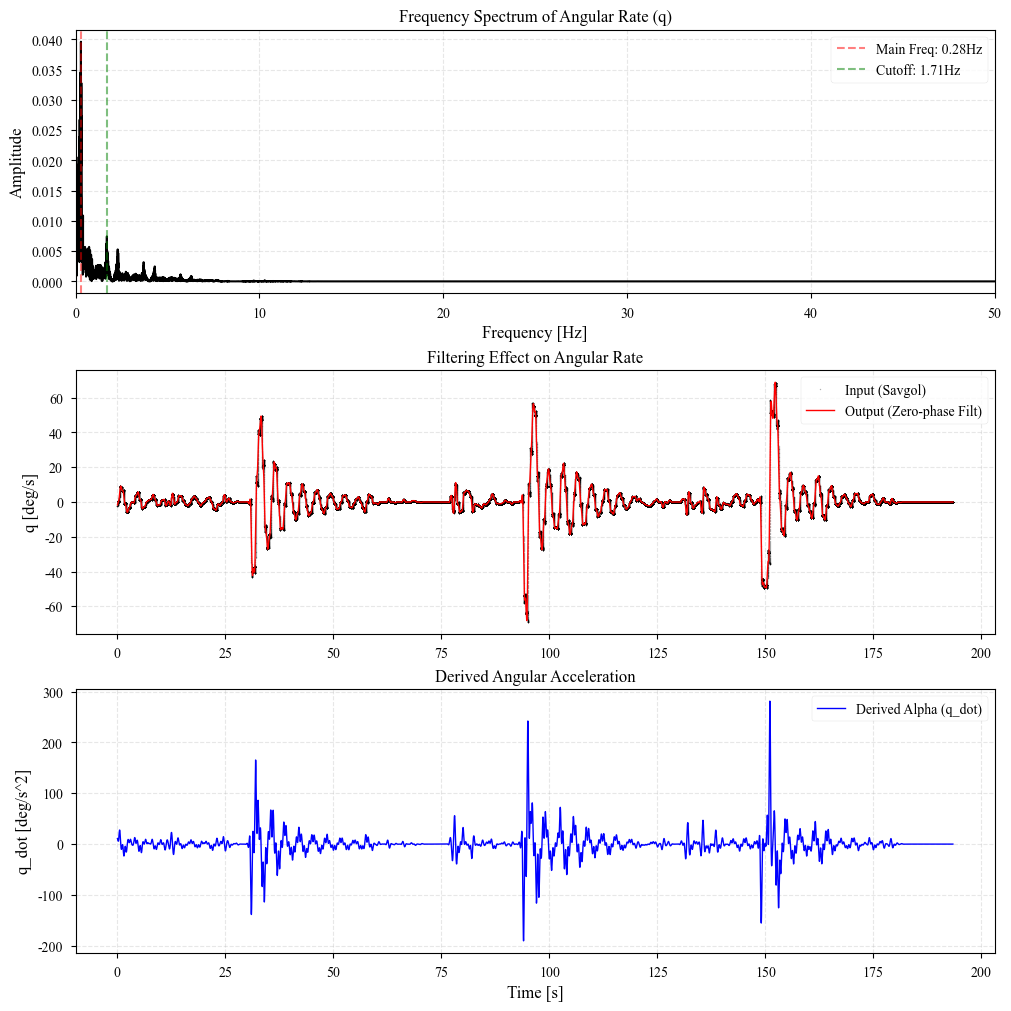

In [5]:
from scipy.signal import butter, filtfilt, welch

# --- Step 1: Advanced Signal Processing for Identification ---

# 1. Data Preparation
# Recalculate time step from the uniform grid in df2
t_proc = df2['Time_s'].values
dt_proc = t_proc[1] - t_proc[0]
q_proc = df2['q_Phys_rad'].values
theta_proc = df2['Theta_Phys_rad'].values

# 2. Spectral Analysis (FFT) to determine Cutoff Frequency
n_samples = len(q_proc)
freqs = np.fft.rfftfreq(n_samples, d=dt_proc)
fft_mag = np.abs(np.fft.rfft(q_proc)) / n_samples

# Find Dominant Frequency (skip DC component at index 0)
dom_idx = np.argmax(fft_mag[1:]) + 1
f_dom = freqs[dom_idx]

print(f"--- Spectral Analysis ---")
print(f"Dominant Oscillation Frequency: {f_dom:.3f} Hz")

# 3. Filter Design (Butterworth Lowpass)
# Strategy: Cutoff at 6x dominant frequency to keep dynamics but kill noise
f_cutoff_ratio = 6.0 
f_cutoff = f_cutoff_ratio * f_dom
nyquist = 0.5 / dt_proc
b, a = butter(N=4, Wn=f_cutoff / nyquist, btype='low')

print(f"Filter Cutoff Frequency: {f_cutoff:.3f} Hz (Factor: {f_cutoff_ratio}x)")

# 4. Zero-phase Filtering (filtfilt) & Differentiation
# Apply filter to both Theta and q for consistency
q_filt = filtfilt(b, a, q_proc)
theta_filt = filtfilt(b, a, theta_proc)

# Compute Angular Acceleration (q_dot) using gradient
q_dot_filt = np.gradient(q_filt, dt_proc)

# Store in DataFrame for next steps
df2['q_filt_rad'] = q_filt
df2['Theta_filt_rad'] = theta_filt
df2['q_dot_filt_rad'] = q_dot_filt
df2['q_dot_filt_deg'] = np.degrees(q_dot_filt) # For checking

# --- Visualization of Step 1 Results ---
fig, axes = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)

# Plot 1: Spectrum
axes[0].plot(freqs, fft_mag, 'k-', lw=1.5)
axes[0].axvline(f_dom, color='r', linestyle='--', alpha=0.5, label=f'Main Freq: {f_dom:.2f}Hz')
axes[0].axvline(f_cutoff, color='g', linestyle='--', alpha=0.5, label=f'Cutoff: {f_cutoff:.2f}Hz')
axes[0].set_xlim(0, 50) # Zoom in on low freq
axes[0].set_title('Frequency Spectrum of Angular Rate (q)')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Filtering Effect on q
axes[1].plot(t_proc, df2['q_Phys_deg'], 'k.', ms=2, alpha=0.3, label='Input (Savgol)')
axes[1].plot(t_proc, np.degrees(q_filt), 'r-', lw=1, label='Output (Zero-phase Filt)')
axes[1].set_title('Filtering Effect on Angular Rate')
axes[1].set_ylabel('q [deg/s]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Derived Angular Acceleration
axes[2].plot(t_proc, df2['q_dot_filt_deg'], 'b-', lw=1, label='Derived Alpha (q_dot)')
axes[2].set_title('Derived Angular Acceleration')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('q_dot [deg/s^2]')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.show()

## 2. Select Identification Range
Use the slider to select the time window for identification (e.g., exclude initial transient or noisy tail).

--- Automated Segmentation Report ---
[Segment 1 (Target ~49.9°)] Start Locked: t=32.248s, theta=49.88° | Len: 42753
[Segment 2 (Target ~31.0°)] Start Locked: t=95.296s, theta=30.87° | Len: 34705
[Segment 3 (Target ~2.5°)] Start Locked: t=150.791s, theta=2.05° | Len: 39210

Total Stacked Samples for Identification: 116668


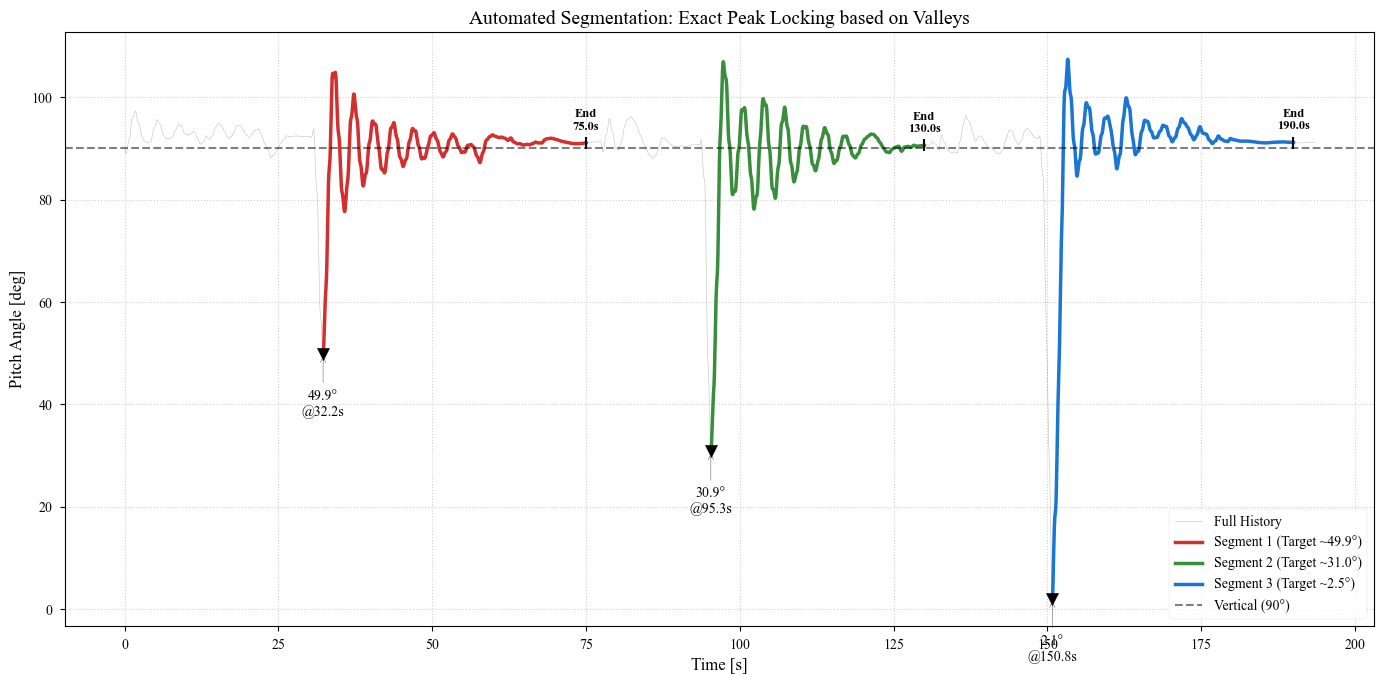

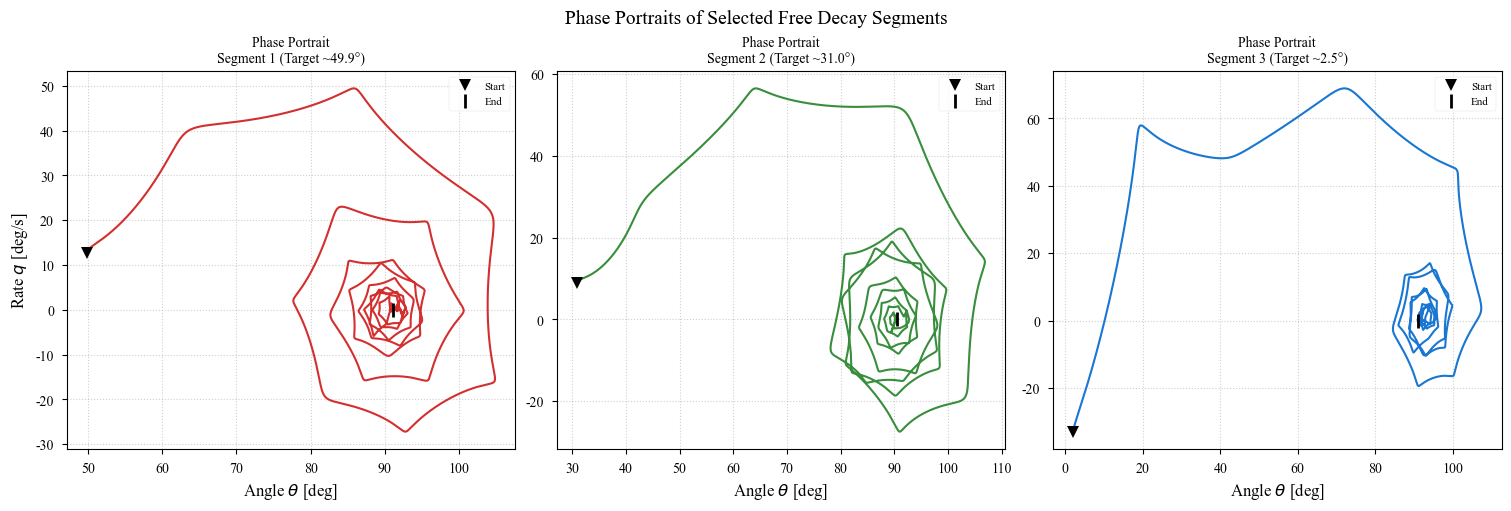

In [6]:
# --- Step 2: Algorithmic Segmentation (Peak Locking) ---

# Define Search Windows for the Start Points based on visual inspection of the "Attitude History" plot
# We look for the local MINIMA (valleys) corresponding to ~49.9, ~31.0, ~2.5 degrees.
# Structure: (Search_Start_Time, Search_End_Time, Exact_Cut_End_Time, Description)
search_configs = [
    (30.0, 36.0, 75.0, "Segment 1 (Target ~49.9°)"),
    (94.0, 100.0, 130.0, "Segment 2 (Target ~31.0°)"),
    (145.0, 155.0, 190.0, "Segment 3 (Target ~2.5°)")
]

Theta_stack = []
q_stack = []
q_dot_stack = []

# Prepare Visualization
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Plot the full background signal for context
ax.plot(df2['Time_s'], np.degrees(df2['Theta_filt_rad']), 'k-', linewidth=0.5, alpha=0.2, label='Full History')

print("--- Automated Segmentation Report ---")

color_cycle = ['#D32F2F', '#388E3C', '#1976D2'] # Red, Green, Blue

for i, (search_t0, search_t1, cut_t_end, desc) in enumerate(search_configs):
    # 1. Isolate the search region to find the specific peak/valley
    region_mask = (df2['Time_s'] >= search_t0) & (df2['Time_s'] <= search_t1)
    df_region = df2.loc[region_mask]
    
    if df_region.empty:
        print(f"Warning: Search region empty for {desc}")
        continue
        
    # 2. Find the exact MINIMUM index in this region (valleys below 90)
    # Using filtered data for precision
    min_idx = df_region['Theta_filt_rad'].idxmin()
    
    # Retrieve exact start parameters
    t_start_exact = df2.loc[min_idx, 'Time_s']
    val_start_rad = df2.loc[min_idx, 'Theta_filt_rad']
    val_start_deg = np.degrees(val_start_rad)
    
    # 3. Slice the Segment (Start at Exact Peak -> Fixed End Time)
    # Note: We cut from the exact peak to capture the full decay
    seg_mask = (df2['Time_s'] >= t_start_exact) & (df2['Time_s'] <= cut_t_end)
    
    th_seg = df2.loc[seg_mask, 'Theta_filt_rad'].values
    q_seg = df2.loc[seg_mask, 'q_filt_rad'].values
    qd_seg = df2.loc[seg_mask, 'q_dot_filt_rad'].values
    t_seg = df2.loc[seg_mask, 'Time_s'].values
    
    # Append to stack
    Theta_stack.append(th_seg)
    q_stack.append(q_seg)
    q_dot_stack.append(qd_seg)
    
    # 4. Visualization of the Segment
    color = color_cycle[i % len(color_cycle)]
    ax.plot(t_seg, np.degrees(th_seg), color=color, linewidth=2.5, label=f'{desc}')
    
    # Mark Start Point
    ax.scatter([t_start_exact], [val_start_deg], color='k', s=80, marker='v', zorder=10)
    ax.annotate(f"{val_start_deg:.1f}°\n@{t_start_exact:.1f}s", 
                xy=(t_start_exact, val_start_deg), 
                xytext=(0, -25), textcoords="offset points", 
                ha='center', va='top', fontsize=10, 
                arrowprops=dict(arrowstyle="->", color='k'))

    # Mark End Point
    if len(t_seg) > 0:
        t_end_actual = t_seg[-1]
        val_end_deg = np.degrees(th_seg[-1])
        ax.scatter([t_end_actual], [val_end_deg], color='k', s=80, marker='|', zorder=10)
        ax.text(t_end_actual, val_end_deg + 2, f"End\n{cut_t_end}s", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    print(f"[{desc}] Start Locked: t={t_start_exact:.3f}s, theta={val_start_deg:.2f}° | Len: {len(th_seg)}")

# Concatenate all stacks into single arrays for Regression
if len(Theta_stack) > 0:
    Theta_all = np.concatenate(Theta_stack)
    q_all = np.concatenate(q_stack)
    q_dot_all = np.concatenate(q_dot_stack)
    print(f"\nTotal Stacked Samples for Identification: {len(Theta_all)}")
else:
    print("\nError: No valid segments found.")
    Theta_all = np.array([])
    q_all = np.array([])
    q_dot_all = np.array([])

# Finalize Plot
ax.axhline(90, color='k', linestyle='--', alpha=0.5, label='Vertical (90°)')
ax.set_title('Automated Segmentation: Exact Peak Locking based on Valleys', fontsize=14)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_ylabel('Pitch Angle [deg]', fontsize=12)
ax.legend(loc='lower right', frameon=True)
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Visualization: Phase Portraits (1 row, 3 columns) ---
if len(Theta_stack) > 0:
    fig_phase, axes_phase = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    
    for i, ax_p in enumerate(axes_phase):
        if i < len(Theta_stack):
            th_deg = np.degrees(Theta_stack[i])
            q_deg = np.degrees(q_stack[i])
            desc = search_configs[i][3] # Get description
            
            # Plot trajectory
            # Use same colors as time plot
            color = color_cycle[i % len(color_cycle)]
            ax_p.plot(th_deg, q_deg, color=color, linewidth=1.5)
            
            # Mark Start (Triangle Down)
            ax_p.plot(th_deg[0], q_deg[0], 'kv', markersize=8, label='Start')
            
            # Mark End (Vertical Bar)
            ax_p.plot(th_deg[-1], q_deg[-1], 'k|', markersize=10, markeredgewidth=2, label='End')
            
            # Formatting
            ax_p.set_title(f'Phase Portrait\n{desc}', fontsize=10)
            ax_p.set_xlabel(r'Angle $\theta$ [deg]')
            if i == 0:
                ax_p.set_ylabel(r'Rate $q$ [deg/s]')
            ax_p.grid(True, linestyle=':', alpha=0.6)
            ax_p.legend(loc='best', fontsize=8)
        else:
            ax_p.axis('off')
            
    fig_phase.suptitle('Phase Portraits of Selected Free Decay Segments', fontsize=14)
    plt.show()

## 3. Decoupled Identification: Step 1 - Kinematics & Frequency

### 3.1 辨识新思路：分步解耦 (Stepwise Decoupling)
为了避免逆动力学回归中的“惯量-刚度”共线性陷阱，我们将辨识过程拆解为物理上独立的步骤：

1.  **Step 1: 频率锁定 (Frequency Locking)**
    *   通过统计波峰/波谷的时间差，精确计算系统的实际振荡频率 $\omega_d$。
    *   这是系统最可靠的“指纹”，不依赖于任何力学模型假设。

2.  **Step 2: 刚度/惯量约束 (Stiffness/Inertia Constraints)** (后续步骤)
    *   利用 $K = I \omega^2$ 关系，检查“几何刚度” $K_{geo}$ 与“理论惯量”是否匹配。
    *   确定是修正在 $K$ (线缆影响) 还是在 $I$ ($\mu$ 渗透率)。

3.  **Step 3: 能量衰减 (Energy Decay)** (后续步骤)
    *   利用振幅衰减率辨识阻尼系数，彻底规避微分噪声。

 STEP 1: ROBUST FREQUENCY LOCKING (Peaks + Zero-Cross + ACF + PSD)
Peak params: MIN_DIST=0.40s (400 samples), HEIGHT>0.5deg, PROM>0.3deg
Period gate: [1.0, 8.0] s | MAD(z<=3.5)
----------------------------------------------------------------------
Seg 1 [OK]: peaks(max/min)=12/8 | T_peak_med=3.0320s(n=11) | T_zc_med=3.1791s(n=14) | T_ac=3.1300s | T_psd=3.1969s | omega_peak=2.072, omega_zc=1.976, omega_ac=2.007, omega_psd=1.965 rad/s
Seg 2 [OK]: peaks(max/min)=8/9 | T_peak_med=3.4765s(n=8) | T_zc_med=3.3187s(n=13) | T_ac=3.2760s | T_psd=3.2768s | omega_peak=1.807, omega_zc=1.893, omega_ac=1.918, omega_psd=1.917 rad/s
Seg 3 [OK]: peaks(max/min)=10/4 | T_peak_med=3.0140s(n=9) | T_zc_med=3.0888s(n=7) | T_ac=nans | T_psd=3.1208s | omega_peak=2.085, omega_zc=2.034, omega_ac=nan, omega_psd=2.013 rad/s
----------------------------------------------------------------------
GLOBAL (robust, source=ZC) from 34 periods:
  T_median = 3.1984 s | IQR = 0.2161 s
  f_d      = 0.3127 Hz
  omega_d  = 1.96

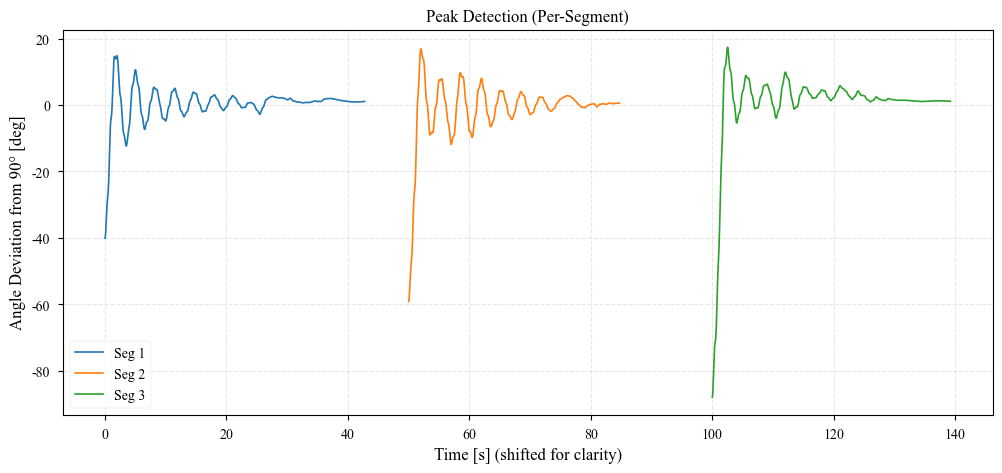

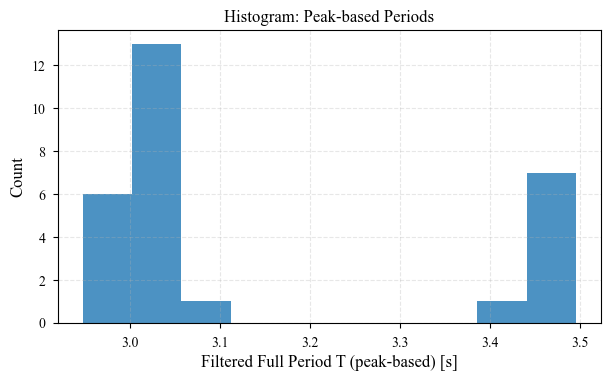

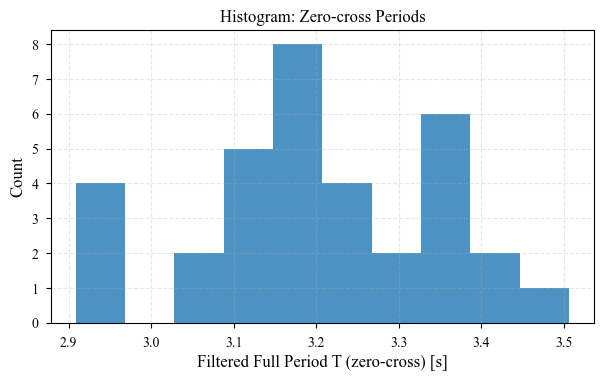

In [7]:
# --- Step 1: Kinematic Frequency Analysis (ROBUST, PER-SEGMENT) ---

print("="*70)
print(" STEP 1: ROBUST FREQUENCY LOCKING (Peaks + Zero-Cross + ACF + PSD)")
print("="*70)

# Goal: get a physically trustworthy damped frequency omega_d from free decay.
# Failure modes to avoid: missed peaks -> measured period doubles (2T); false split -> T/2.
# Strategy (per segment):
#   A) Full-period from same-type extrema (max-to-max, min-to-min) + MAD outlier rejection
#   B) Full-period from zero-crossings (t[k+2]-t[k]) + MAD outlier rejection
#   C) Autocorrelation (ACF): pick the FIRST credible ACF peak (avoid 2T)
#   D) PSD peak (Welch) as an independent frequency estimator (with sufficient frequency resolution)
# Then: report per-segment medians + consistency flags; global omega uses the most reliable estimator available.

from scipy.signal import welch

dt_uniform = 0.001  # 1000 Hz grid from interpolation step

# Physical prior (broad, but excludes nonsense)
T_MIN, T_MAX = 1.0, 8.0   # seconds; adjust only if you have strong evidence
F_MIN, F_MAX = 1.0/T_MAX, 1.0/T_MIN
MIN_DIST_S = 0.40          # peak refractory time [s] to avoid double-counting noise
HEIGHT_DEG = 0.5           # minimum excursion [deg] from 90deg to count as peak
PROM_DEG = 0.3             # prominence threshold [deg]
min_dist_samples = int(MIN_DIST_S / dt_uniform)

def _robust_filter_periods(periods_s, t_min=T_MIN, t_max=T_MAX):
    periods_s = np.asarray(periods_s, dtype=float)
    if periods_s.size == 0:
        return periods_s
    # 1) Physical gate
    periods_s = periods_s[(periods_s >= t_min) & (periods_s <= t_max)]
    if periods_s.size < 3:
        return periods_s
    # 2) MAD outlier rejection
    med = np.median(periods_s)
    mad = np.median(np.abs(periods_s - med))
    if mad == 0:
        return periods_s
    z = 0.6745 * (periods_s - med) / mad  # robust z-score
    return periods_s[np.abs(z) <= 3.5]

def _zero_crossing_times(x, dt):
    """Return interpolated zero-crossing times (s) for signal x sampled at dt."""
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.array([])
    s = np.sign(x)
    # treat exact zeros as tiny positives to avoid spurious 'no sign change'
    s[s == 0] = 1.0
    idx = np.where(s[:-1] * s[1:] < 0)[0]  # sign change between i and i+1
    if idx.size == 0:
        return np.array([])
    x0 = x[idx]
    x1 = x[idx + 1]
    denom = (x1 - x0)
    denom[denom == 0] = np.nan
    alpha = -x0 / denom
    t = (idx + alpha) * dt
    t = t[np.isfinite(t)]
    return t

def _zc_full_periods(x, dt):
    """Full periods from zero crossings: T ≈ t[k+2] - t[k]."""
    tzc = _zero_crossing_times(x, dt)
    if tzc.size < 3:
        return np.array([])
    return tzc[2:] - tzc[:-2]

def _autocorr_period_first_peak(x, dt, t_min=T_MIN, t_max=T_MAX):
    """Estimate period by the first credible peak of ACF within [t_min, t_max]."""
    x = np.asarray(x, dtype=float)
    if x.size < 10:
        return np.nan
    x = x - np.mean(x)
    denom = np.dot(x, x)
    if denom <= 0:
        return np.nan
    ac = np.correlate(x, x, mode='full')[x.size-1:] / denom
    lag_min = int(t_min / dt)
    lag_max = min(int(t_max / dt), ac.size - 1)
    if lag_max <= lag_min + 5:
        return np.nan
    ac_win = ac[lag_min:lag_max+1]
    # Find peaks; choose the earliest one above a modest threshold
    pks, props = find_peaks(ac_win, prominence=0.05, height=0.10, distance=max(1, int(0.2 / dt)))
    if pks.size == 0:
        return np.nan
    best = int(pks.min())  # earliest peak reduces risk of picking 2T
    lag = lag_min + best
    return lag * dt

def _psd_period(x, dt, f_min=F_MIN, f_max=F_MAX):
    """Estimate period from PSD peak in [f_min, f_max] using Welch with higher frequency resolution."""
    x = np.asarray(x, dtype=float)
    if x.size < 512:
        return np.nan
    fs = 1.0 / dt
    # Use long segments to improve resolution; add nfft zero-padding for finer bins.
    nperseg = min(16384, x.size)
    if nperseg < 512:
        return np.nan
    nfft = int(8 * 2 ** np.ceil(np.log2(nperseg)))  # zero-pad to refine frequency grid
    f, Pxx = welch(x - np.mean(x), fs=fs, nperseg=nperseg, noverlap=nperseg//2, nfft=nfft, detrend='constant')
    mask = (f >= f_min) & (f <= f_max)
    if not np.any(mask):
        return np.nan
    f_sel = f[mask]
    P_sel = Pxx[mask]
    idx = int(np.argmax(P_sel))
    f0 = float(f_sel[idx])
    if f0 <= 0:
        return np.nan
    return 1.0 / f0

# Containers
segment_results = []
all_T_peak = []
all_T_zc = []

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
shift_s = 0.0
shift_step = 50.0  # seconds, for visual separation only

for seg_idx, th_seg_rad in enumerate(Theta_stack):
    th_deg = np.degrees(th_seg_rad)
    centered = th_deg - 90.0

    # A) Peak-based periods (full cycles)
    pks_max, _ = find_peaks(centered, distance=min_dist_samples, height=HEIGHT_DEG, prominence=PROM_DEG)
    pks_min, _ = find_peaks(-centered, distance=min_dist_samples, height=HEIGHT_DEG, prominence=PROM_DEG)
    T_max = np.diff(pks_max) * dt_uniform if len(pks_max) >= 2 else np.array([])
    T_min = np.diff(pks_min) * dt_uniform if len(pks_min) >= 2 else np.array([])
    T_peak_raw = np.concatenate([T_max, T_min]) if (T_max.size + T_min.size) else np.array([])
    T_peak = _robust_filter_periods(T_peak_raw)

    # B) Zero-crossing based periods (full cycles)
    T_zc_raw = _zc_full_periods(centered, dt_uniform)
    T_zc = _robust_filter_periods(T_zc_raw)

    # C) Autocorrelation (first peak)
    T_ac = _autocorr_period_first_peak(centered, dt_uniform)

    # D) PSD peak
    T_psd = _psd_period(centered, dt_uniform)

    # Robust summary
    T_peak_med = float(np.median(T_peak)) if T_peak.size else np.nan
    T_zc_med = float(np.median(T_zc)) if T_zc.size else np.nan
    omega_peak = 2 * np.pi / T_peak_med if np.isfinite(T_peak_med) and T_peak_med > 0 else np.nan
    omega_zc = 2 * np.pi / T_zc_med if np.isfinite(T_zc_med) and T_zc_med > 0 else np.nan
    omega_ac = 2 * np.pi / T_ac if np.isfinite(T_ac) and T_ac > 0 else np.nan
    omega_psd = 2 * np.pi / T_psd if np.isfinite(T_psd) and T_psd > 0 else np.nan

    # Consistency flag: primary check is ZC vs PEAK; PSD/ACF are cross-checks
    flag = "OK"
    if np.isfinite(T_zc_med) and np.isfinite(T_peak_med):
        rel = abs(T_zc_med - T_peak_med) / ((T_zc_med + T_peak_med) / 2.0)
        if rel > 0.10:
            flag = "CHECK"
    elif np.isfinite(T_zc_med) or np.isfinite(T_peak_med):
        flag = "CHECK"
    else:
        flag = "FAIL"

    segment_results.append({
        "seg": seg_idx + 1,
        "n_max": int(len(pks_max)),
        "n_min": int(len(pks_min)),
        "T_peak_n": int(T_peak.size),
        "T_zc_n": int(T_zc.size),
        "T_peak_med": T_peak_med,
        "T_zc_med": T_zc_med,
        "T_ac": float(T_ac) if np.isfinite(T_ac) else np.nan,
        "T_psd": float(T_psd) if np.isfinite(T_psd) else np.nan,
        "omega_peak": omega_peak,
        "omega_zc": omega_zc,
        "omega_ac": omega_ac,
        "omega_psd": omega_psd,
        "flag": flag,
    })

    if T_peak.size:
        all_T_peak.append(T_peak)
    if T_zc.size:
        all_T_zc.append(T_zc)

    # Plot signal + detected peaks
    t_axis = np.arange(centered.size) * dt_uniform + shift_s
    ax.plot(t_axis, centered, lw=1.2, label=f"Seg {seg_idx+1}")
    if len(pks_max):
        ax.plot(t_axis[pks_max], centered[pks_max], 'rx', ms=5)
    if len(pks_min):
        ax.plot(t_axis[pks_min], centered[pks_min], 'bx', ms=5)
    shift_s += shift_step

# Print report
print(f"Peak params: MIN_DIST={MIN_DIST_S:.2f}s ({min_dist_samples} samples), HEIGHT>{HEIGHT_DEG}deg, PROM>{PROM_DEG}deg")
print(f"Period gate: [{T_MIN:.1f}, {T_MAX:.1f}] s | MAD(z<=3.5)")
print("-" * 70)
for r in segment_results:
    print(
        f"Seg {r['seg']} [{r['flag']}]: peaks(max/min)={r['n_max']}/{r['n_min']} | "
        f"T_peak_med={r['T_peak_med']:.4f}s(n={r['T_peak_n']}) | "
        f"T_zc_med={r['T_zc_med']:.4f}s(n={r['T_zc_n']}) | "
        f"T_ac={r['T_ac']:.4f}s | T_psd={r['T_psd']:.4f}s | "
        f"omega_peak={r['omega_peak']:.3f}, omega_zc={r['omega_zc']:.3f}, omega_ac={r['omega_ac']:.3f}, omega_psd={r['omega_psd']:.3f} rad/s"
    )
print("-" * 70)

# Global robust omega: prefer ZC aggregate, then PSD (per-seg), then PEAK aggregate
T_all_zc = np.concatenate(all_T_zc) if len(all_T_zc) else np.array([])
T_all_peak = np.concatenate(all_T_peak) if len(all_T_peak) else np.array([])
T_all_psd = np.array([r["T_psd"] for r in segment_results if np.isfinite(r["T_psd"])])

src = None
if T_all_zc.size >= 6:
    T_all = T_all_zc
    src = "ZC"
elif T_all_psd.size >= 2:
    T_all = T_all_psd
    src = "PSD"
else:
    T_all = T_all_peak
    src = "PEAK"

T_all = _robust_filter_periods(T_all)
if T_all.size >= 2:
    T_med = float(np.median(T_all))
    T_iqr = float(np.percentile(T_all, 75) - np.percentile(T_all, 25)) if T_all.size >= 4 else np.nan
    omega_d_final = 2 * np.pi / T_med
    f_d_final = 1.0 / T_med
    print(f"GLOBAL (robust, source={src}) from {T_all.size} periods:")
    print(f"  T_median = {T_med:.4f} s" + (f" | IQR = {T_iqr:.4f} s" if np.isfinite(T_iqr) else ""))
    print(f"  f_d      = {f_d_final:.4f} Hz")
    print(f"  omega_d  = {omega_d_final:.4f} rad/s")
else:
    print("ERROR: Not enough valid period estimates after filtering.")
    omega_d_final = np.nan
    f_d_final = np.nan

# Theoretical comparison (note: omega_d is damped; omega_n >= omega_d)
if np.isfinite(omega_d_final):
    K_geo_val = B_force * x_b
    omega_dry = np.sqrt(K_geo_val / I_yy_dry)
    omega_virtual_mu06 = np.sqrt(K_geo_val / I_virtual)
    print("-" * 70)
    print(f"Theoretical omega_n (dry, mu=0):  {omega_dry:.4f} rad/s")
    print(f"Theoretical omega_n (mu=0.6):     {omega_virtual_mu06:.4f} rad/s")
    print("NOTE: This is omega_d (measured) vs omega_n (undamped approx).")
    omega_exp = omega_d_final
else:
    omega_exp = None

# Plot formatting
ax.set_title('Peak Detection (Per-Segment)')
ax.set_xlabel('Time [s] (shifted for clarity)')
ax.set_ylabel('Angle Deviation from 90° [deg]')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.show()

# Histograms
if T_all_peak.size:
    plt.figure(figsize=(7, 3.8))
    plt.hist(T_all_peak, bins=min(30, max(10, int(np.sqrt(T_all_peak.size)))), alpha=0.8)
    plt.xlabel('Filtered Full Period T (peak-based) [s]')
    plt.ylabel('Count')
    plt.title('Histogram: Peak-based Periods')
    plt.grid(True, alpha=0.3)
    plt.show()
if T_all_zc.size:
    plt.figure(figsize=(7, 3.8))
    plt.hist(T_all_zc, bins=min(30, max(10, int(np.sqrt(T_all_zc.size)))), alpha=0.8)
    plt.xlabel('Filtered Full Period T (zero-cross) [s]')
    plt.ylabel('Count')
    plt.title('Histogram: Zero-cross Periods')
    plt.grid(True, alpha=0.3)
    plt.show()

In [8]:
# --- Step 2: Stiffness & Inertia Decoupling (Constraint Analysis) ---

print("="*60)
print(" STEP 2: STIFFNESS–INERTIA DECOUPLING (μ and K_cable feasibility)")
print("="*60)

# This step uses the locked damped frequency from Step 1 (omega_d_final).
# Assumption for constraint analysis: omega_n ≈ omega_d (light-to-moderate damping).
# If damping is strong, omega_n will be slightly higher than omega_d; interpret ranges accordingly.

try:
    omega_exp = float(omega_d_final)
except NameError:
    raise RuntimeError("omega_d_final not defined. Run Step 1 first.")

# Pull robust period samples from Step 1 if available (preferred for uncertainty)
omega_q25 = omega_exp
omega_q75 = omega_exp
try:
    if 'T_all' in globals():
        T_all_local = np.asarray(T_all, dtype=float)
        T_all_local = T_all_local[np.isfinite(T_all_local) & (T_all_local > 0)]
        if T_all_local.size >= 8:
            omega_samples = 2 * np.pi / T_all_local
            omega_q25 = float(np.percentile(omega_samples, 25))
            omega_q75 = float(np.percentile(omega_samples, 75))
except Exception:
    pass

omega_lo = min(omega_q25, omega_q75)
omega_hi = max(omega_q25, omega_q75)

# Known restoring slope from geometry (about equilibrium)
K_geo_val = float(B_force * x_b)  # Nm/rad
I_base = float(I_yy_dry - M_q_outer)  # = I_dry - (outer added mass term); M_q_outer is negative
I_water = float(I_water_inner)

def I_total(mu):
    return I_base + mu * I_water

def mu_at_Kcable0(omega):
    # K_total = K_geo when K_cable = 0 => I = K_geo/omega^2 => solve mu
    I_req = K_geo_val / (omega**2)
    return (I_req - I_base) / I_water

def K_cable_required(mu, omega):
    # K_total = I(μ) * ω^2 = K_geo + K_cable
    return I_total(mu) * (omega**2) - K_geo_val

# --- Compact feasibility report ---
print(f"Locked experimental omega_d: {omega_exp:.4f} rad/s")
print(f"Omega IQR-band (from ZC periods): [{omega_lo:.4f}, {omega_hi:.4f}] rad/s")
print(f"K_geo (geometry): {K_geo_val:.5f} Nm/rad")
print(f"Inertia model: I(μ)=I_base + μ*I_water,  I_base={I_base:.5f}, I_water={I_water:.5f} kg·m^2")
print("-"*60)

# μ that would make K_cable = 0 (cable-free consistency point)
mu0_med = float(mu_at_Kcable0(omega_exp))
mu0_lo = float(mu_at_Kcable0(omega_hi))  # omega higher -> mu0 smaller
mu0_hi = float(mu_at_Kcable0(omega_lo))  # omega lower -> mu0 larger
mu0_band_lo = min(mu0_lo, mu0_hi)
mu0_band_hi = max(mu0_lo, mu0_hi)

# If we assume cables only ADD restoring stiffness (K_cable >= 0), then μ must satisfy μ >= μ0(ω).
mu_min_conservative = max(0.0, mu0_band_hi)
mu_min_nominal = max(0.0, mu0_med)

# K_cable range at μ=1 (max plausible inertia) under omega band
Kc_mu1_lo = float(K_cable_required(1.0, omega_lo))
Kc_mu1_hi = float(K_cable_required(1.0, omega_hi))
Kc_mu1_band_lo = min(Kc_mu1_lo, Kc_mu1_hi)
Kc_mu1_band_hi = max(Kc_mu1_lo, Kc_mu1_hi)

print("Feasibility (assuming K_cable ≥ 0 adds stiffness):")
print(f"  μ0 (K_cable=0) nominal: {mu0_med:.4f}")
print(f"  μ0 band from omega-IQR: [{mu0_band_lo:.4f}, {mu0_band_hi:.4f}]")
print(f"  ⇒ Conservative μ feasible range: [ {mu_min_conservative:.4f}, 1.0000 ]")
print(f"  Corresponding K_cable at μ=1 (omega-IQR band): [{Kc_mu1_band_lo:.5f}, {Kc_mu1_band_hi:.5f}] Nm/rad")
print("-"*60)

# Sanity interpretation flags
if mu0_med < 0:
    print("[FLAG] μ0<0: Even μ=0 would require K_total<K_geo to match omega.")
    print("       This suggests additional hydro moment reduction or model mismatch.")
elif mu0_med > 1:
    print("[FLAG] μ0>1: Even μ=1 would require K_total>K_geo by a lot (or omega too low).")
    print("       Check frequency lock, K_geo, and inertia terms.")
else:
    print("[OK] μ0 within [0,1]: cable-free (K_cable≈0) is physically possible.")

print("="*60)

# --- Keep original Step2 logic outputs for downstream steps ---
# Scenario A: Assume K_eff = K_geo (no cable stiffness correction)
I_implied = K_geo_val / (omega_exp**2)
mu_implied = (I_implied - I_yy_dry + M_q_outer) / I_water_inner  # same as mu0_med
print("SCENARIO A (K_eff = K_geo):")
print(f"  I_implied = {I_implied:.5f} kg·m^2")
print(f"  μ_implied = {mu_implied:.4f}")

if 0.0 <= mu_implied <= 1.0:
    is_scenario_A = True
    print("  -> Plausible: adopt Scenario A as baseline (K_cable≈0).")
else:
    is_scenario_A = False
    print("  -> Not plausible: need stiffness correction (cable/hydro) or revisit assumptions.")

print("-"*60)

# Scenario B: If needed, fix μ and infer K_cable
mu_fix_default = 0.5
mu_fix = float(np.clip(mu_fix_default, mu_min_conservative, 1.0))
M_q_fix = M_q_outer - mu_fix * I_water_inner
I_fix = I_yy_dry - M_q_fix
K_implied = I_fix * (omega_exp**2)
K_cable_est = K_implied - K_geo_val

print("SCENARIO B (fix μ, infer K_cable):")
print(f"  μ_fix = {mu_fix:.4f} (default {mu_fix_default} clipped to feasible)")
print(f"  I_fix = {I_fix:.5f} kg·m^2")
print(f"  K_total = {K_implied:.5f} Nm/rad")
print(f"  K_cable = {K_cable_est:.5f} Nm/rad")
print("="*60)

# Final parameter selection for Step 3 (keep same variable names)
if is_scenario_A:
    I_id = I_implied
    K_eff_ident = K_geo_val
    mu_identified = float(mu_implied)
    K_cab_id = 0.0
    print("DECISION: Scenario A (baseline, K_cable≈0)")
else:
    I_id = I_fix
    K_eff_ident = K_implied
    mu_identified = float(mu_fix)
    K_cab_id = float(K_cable_est)
    print("DECISION: Scenario B (stiffness correction)")

print(f"  -> Using I_id        = {I_id:.5f} kg·m^2")
print(f"  -> Using K_eff_ident = {K_eff_ident:.5f} Nm/rad")
print(f"  -> Using μ (report)  = {mu_identified:.4f}")
print(f"  -> Using K_cable(rep)= {K_cab_id:.5f} Nm/rad")
print("="*60)

 STEP 2: STIFFNESS–INERTIA DECOUPLING (μ and K_cable feasibility)
Locked experimental omega_d: 1.9645 rad/s
Omega IQR-band (from ZC periods): [1.8849, 2.0156] rad/s
K_geo (geometry): 0.63539 Nm/rad
Inertia model: I(μ)=I_base + μ*I_water,  I_base=0.17241, I_water=0.01119 kg·m^2
------------------------------------------------------------
Feasibility (assuming K_cable ≥ 0 adds stiffness):
  μ0 (K_cable=0) nominal: -0.6940
  μ0 band from omega-IQR: [-1.4310, 0.5738]
  ⇒ Conservative μ feasible range: [ 0.5738, 1.0000 ]
  Corresponding K_cable at μ=1 (omega-IQR band): [0.01694, 0.11052] Nm/rad
------------------------------------------------------------
[FLAG] μ0<0: Even μ=0 would require K_total<K_geo to match omega.
       This suggests additional hydro moment reduction or model mismatch.
SCENARIO A (K_eff = K_geo):
  I_implied = 0.16464 kg·m^2
  μ_implied = -0.6940
  -> Not plausible: need stiffness correction (cable/hydro) or revisit assumptions.
---------------------------------------

 STEP 3: ENERGY BALANCE NNLS (full energy ΔE + measured w-integrals, cycle-based)
omega_sys: 1.9645 rad/s | T_ref=3.1984s | gate=[2.239,4.158]s
Cycles total: 39 | used: 30
Filtered: amp=0, T_gate=3, dE<=0=6, bad=0
----------------------------------------------------------------------------------
NNLS identified damping (cycle-based full-energy balance):
  d_q   = 0.000000  [N·m·s/rad]
  d_qq  = 0.264020  [N·m·s^2/rad^2]
  Fit: R^2 = 0.9795 | rnorm = 1.3271e-02
  Amp used: 0.84–17.38 deg (mean 7.13)
  Period used: 2.602–3.399 s
----------------------------------------------------------------------------------


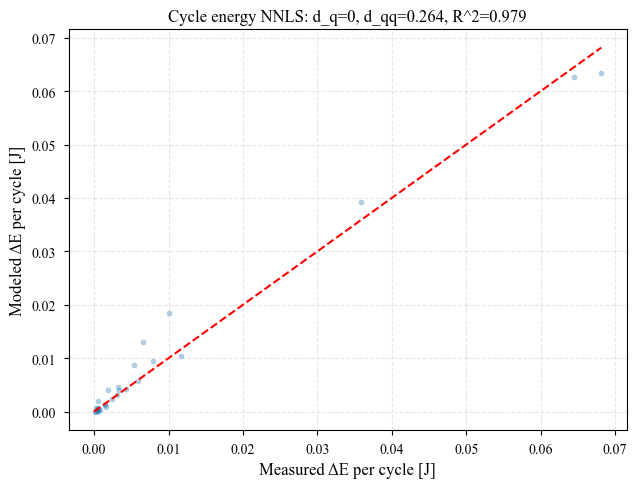

FINAL IDENTIFIED VECTOR (for Step4 init/compare):
beta = [I_id=0.17883, d_q=0.000000, d_qq=0.264020]
K_cable (report from Step2) = 0.05475 Nm/rad


In [9]:
# --- Step 3: Energy Decay Analysis (Damping Identification) ---

print("="*82)
print(" STEP 3: ENERGY BALANCE NNLS (full energy ΔE + measured w-integrals, cycle-based)")
print("="*82)

# Why this form is the 'truth' for the Step4 damping model:
#   I*th_ddot + dq*w + dqq*|w|w + K*th = 0
# Multiply by w and integrate over [t0,t1]:
#   E(t0)-E(t1) = dq*∫ w^2 dt + dqq*∫ |w|^3 dt,  E = 0.5*I*w^2 + 0.5*K*th^2
# This avoids the problematic assumption “w≈0 at peaks” and uses the same dissipation law as Step4.

from scipy.optimize import nnls

I_sys = float(I_id)
K_sys = float(K_eff_ident)
omega_sys = float(np.sqrt(K_sys / I_sys))
T_ref = 2 * np.pi / omega_sys
T_gate_lo = 0.7 * T_ref
T_gate_hi = 1.3 * T_ref

AMP_MIN_DEG = 0.7       # cycle amplitude gate (deg)
MIN_CYCLES = 12         # minimum number of valid cycles for stable NNLS

def _zero_crossing_times_local(x, dt):
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.array([])
    s = np.sign(x)
    s[s == 0] = 1.0
    idx = np.where(s[:-1] * s[1:] < 0)[0]
    if idx.size == 0:
        return np.array([])
    x0 = x[idx]
    x1 = x[idx + 1]
    denom = (x1 - x0)
    denom[denom == 0] = np.nan
    alpha = -x0 / denom
    t = (idx + alpha) * dt
    t = t[np.isfinite(t)]
    return t

def _idx_from_time(t, dt, n):
    i = int(np.round(t / dt))
    return int(np.clip(i, 0, n - 1))

Y_dE = []
X_int_w2 = []
X_int_w3 = []
A_used = []
T_used = []

n_cycles_total = 0
n_cycles_used = 0
n_filtered_amp = 0
n_filtered_T = 0
n_filtered_sign = 0
n_filtered_bad = 0

for seg_idx, th_seg_rad in enumerate(Theta_stack):
    th_deg = np.degrees(th_seg_rad)
    theta = np.radians(th_deg - 90.0)
    n = theta.size
    if n < 3000:
        continue

    # angular rate w (rad/s): prefer q_stack if aligned; else numerical derivative
    w = None
    try:
        if 'q_stack' in globals() and seg_idx < len(q_stack):
            w_candidate = np.asarray(q_stack[seg_idx], dtype=float)
            if w_candidate.size == n and np.all(np.isfinite(w_candidate)):
                w = w_candidate
    except Exception:
        w = None
    if w is None:
        w = np.gradient(theta, dt_uniform)

    # zero crossings to define full cycles: zc[k] -> zc[k+2]
    tzc = _zero_crossing_times_local(theta, dt_uniform)
    if tzc.size < 6:
        continue
    # drop crossings too close to edges
    tzc = tzc[(tzc > 0.2) & (tzc < (n * dt_uniform - 0.2))]
    if tzc.size < 6:
        continue

    for k in range(tzc.size - 2):
        t0 = float(tzc[k])
        t1 = float(tzc[k + 2])
        T = t1 - t0
        n_cycles_total += 1
        if T < T_gate_lo or T > T_gate_hi:
            n_filtered_T += 1
            continue
        i0 = _idx_from_time(t0, dt_uniform, n)
        i1 = _idx_from_time(t1, dt_uniform, n)
        if i1 <= i0 + 20:
            n_filtered_bad += 1
            continue

        # amplitude proxy within the cycle
        A = float(np.max(np.abs(theta[i0:i1+1])))
        if A < np.radians(AMP_MIN_DEG):
            n_filtered_amp += 1
            continue

        # energy at endpoints (full energy)
        E0 = 0.5 * I_sys * (w[i0] ** 2) + 0.5 * K_sys * (theta[i0] ** 2)
        E1 = 0.5 * I_sys * (w[i1] ** 2) + 0.5 * K_sys * (theta[i1] ** 2)
        dE = float(E0 - E1)
        if not np.isfinite(dE) or dE <= 0:
            n_filtered_sign += 1
            continue

        w_seg = w[i0:i1+1]
        int_w2 = float(np.trapezoid(w_seg**2, dx=dt_uniform))
        int_w3 = float(np.trapezoid(np.abs(w_seg)**3, dx=dt_uniform))
        if int_w2 <= 0 or int_w3 < 0 or (not np.isfinite(int_w2)) or (not np.isfinite(int_w3)):
            n_filtered_bad += 1
            continue

        Y_dE.append(dE)
        X_int_w2.append(int_w2)
        X_int_w3.append(int_w3)
        A_used.append(A)
        T_used.append(T)
        n_cycles_used += 1

Y_reg = np.asarray(Y_dE, dtype=float)
X_reg = np.vstack([X_int_w2, X_int_w3]).T if len(X_int_w2) else np.zeros((0, 2), dtype=float)

print(f"omega_sys: {omega_sys:.4f} rad/s | T_ref={T_ref:.4f}s | gate=[{T_gate_lo:.3f},{T_gate_hi:.3f}]s")
print(f"Cycles total: {n_cycles_total} | used: {n_cycles_used}")
print(f"Filtered: amp={n_filtered_amp}, T_gate={n_filtered_T}, dE<=0={n_filtered_sign}, bad={n_filtered_bad}")

if Y_reg.size < MIN_CYCLES:
    raise RuntimeError(f"Not enough valid cycles for NNLS (need >= {MIN_CYCLES}, got {Y_reg.size}).")

# NNLS fit
coeffs_nnls, rnorm = nnls(X_reg, Y_reg)
d_q_final = float(coeffs_nnls[0])
d_qq_final = float(coeffs_nnls[1])

Y_pred = d_q_final * X_reg[:, 0] + d_qq_final * X_reg[:, 1]
SS_res = float(np.sum((Y_reg - Y_pred) ** 2))
SS_tot = float(np.sum((Y_reg - np.mean(Y_reg)) ** 2))
R_squared = 1.0 - SS_res / SS_tot if SS_tot > 0 else np.nan

A_deg = np.degrees(np.asarray(A_used, dtype=float))
print("-" * 82)
print("NNLS identified damping (cycle-based full-energy balance):")
print(f"  d_q   = {d_q_final:.6f}  [N·m·s/rad]")
print(f"  d_qq  = {d_qq_final:.6f}  [N·m·s^2/rad^2]")
print(f"  Fit: R^2 = {R_squared:.4f} | rnorm = {rnorm:.4e}")
print(f"  Amp used: {np.nanmin(A_deg):.2f}–{np.nanmax(A_deg):.2f} deg (mean {np.nanmean(A_deg):.2f})")
print(f"  Period used: {np.nanmin(T_used):.3f}–{np.nanmax(T_used):.3f} s")
print("-" * 82)

plt.figure(figsize=(7.2, 5.2))
plt.scatter(Y_reg, Y_pred, alpha=0.35, s=14)
m = max(np.max(Y_reg), np.max(Y_pred))
plt.plot([0, m], [0, m], 'r--', lw=1.5)
plt.xlabel('Measured ΔE per cycle [J]')
plt.ylabel('Modeled ΔE per cycle [J]')
plt.title(f'Cycle energy NNLS: d_q={d_q_final:.3g}, d_qq={d_qq_final:.3g}, R^2={R_squared:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

print("FINAL IDENTIFIED VECTOR (for Step4 init/compare):")
print(f"beta = [I_id={I_id:.5f}, d_q={d_q_final:.6f}, d_qq={d_qq_final:.6f}]")
print(f"K_cable (report from Step2) = {K_cab_id:.5f} Nm/rad")

 STEP 4: JOINT FIT (global dq,dqq + per-segment K) using BOTH φ(t) and measured ω(t)
I fixed: 0.17883 kg·m² | K_nom: 0.69013 Nm/rad | K bounds: [0.3451,1.0352]
Per-segment ω diagnostics (from φ zero-crossing):
  seg 0: T_med=3.214 s | omega_med=1.955 rad/s | K_init=0.6836
  seg 1: T_med=3.265 s | omega_med=1.925 rad/s | K_init=0.6624
  seg 2: T_med=3.015 s | omega_med=2.084 rad/s | K_init=0.7768

[4.1] Global joint fit on ALL segments...
  optimize success=True | nit=11 | fun=9.6025e-01
Global joint-fit parameters:
  dq  = 0.000000   [N·m·s/rad]
  dqq = 0.404250  [N·m·s²/rad²]
  K[0] = 0.687779  [N·m/rad]
  K[1] = 0.639790  [N·m/rad]
  K[2] = 0.650596  [N·m/rad]

Global-fit metrics (per segment):


,seg,N_ds,T_med_exp_s,omega_exp_rad_s,K_fit_Nm_rad,R2_phi,RMSE_phi_deg,R2_w,RMSE_w_deg_s
0,0,2500,3.213731,1.955106,0.687779,0.907015,1.659638,0.862115,3.455100
1,1,2500,3.264711,1.924577,0.639790,0.875851,3.190297,0.693447,6.908619
2,2,2500,3.014771,2.084134,0.650596,0.943321,3.010527,0.758431,6.275761


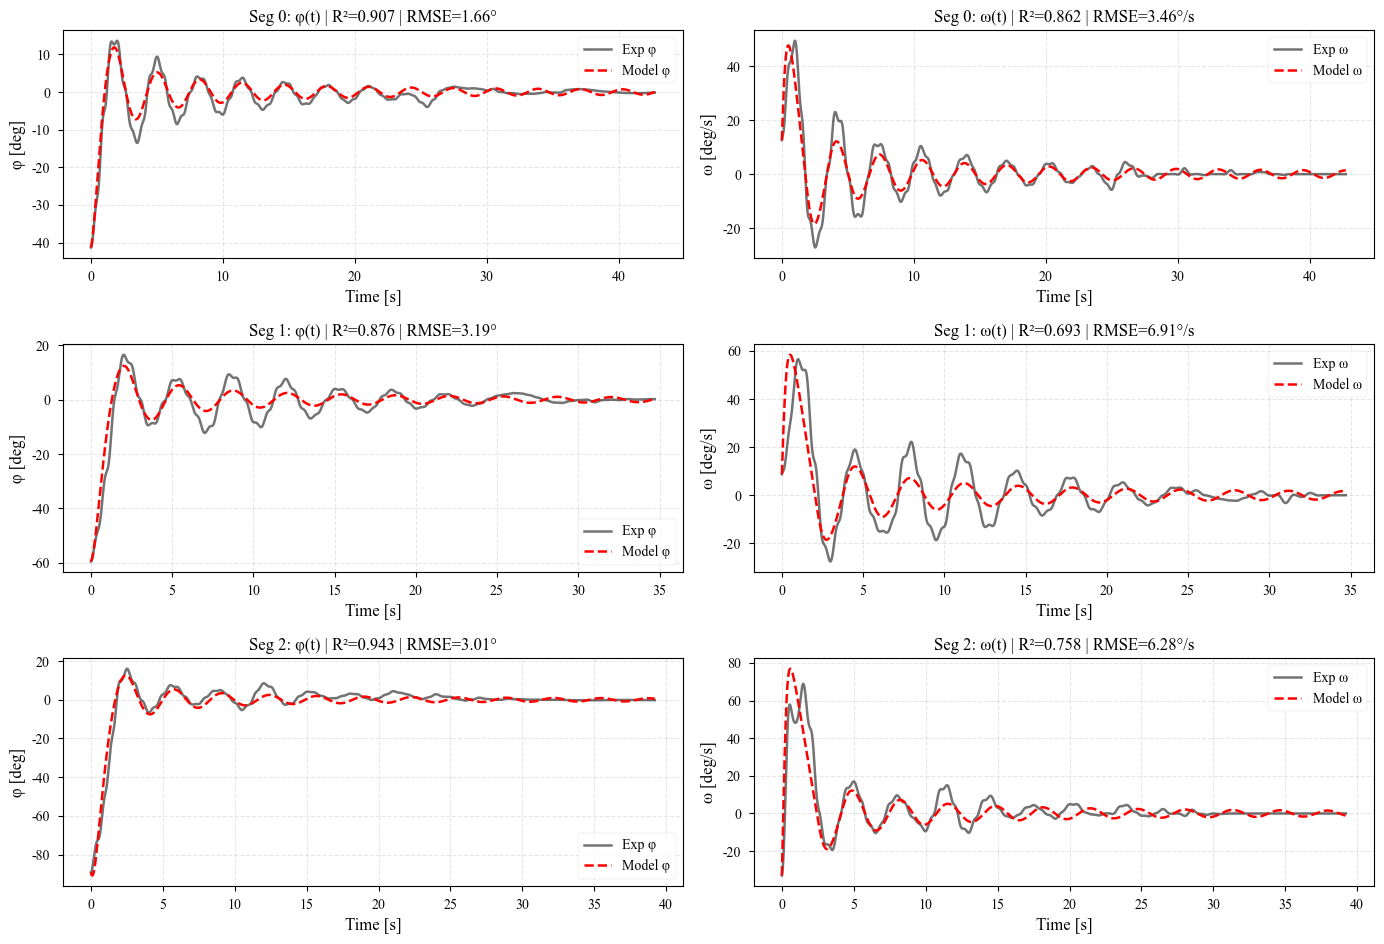


[4.4] 3-fold cross-validation (global damping transferability)...
Cross-validation results (hold-out performance):


,holdout_seg,train_segs,dq_fit,dqq_fit,K_hold_fixed,R2_phi_hold,RMSE_phi_hold_deg,R2_w_hold,RMSE_w_hold_deg_s
0,0,"[1, 2]",0.0,0.479683,0.683570,0.883546,1.857309,0.825996,3.881336
1,1,"[0, 2]",0.0,0.408737,0.662389,0.868847,3.279049,0.678954,7.070049
2,2,"[0, 1]",0.0,0.340838,0.776772,0.838064,5.088657,0.378752,10.064189



CV summary (dq,dqq):
  dq  mean±std = 0.000000 ± 0.000000
  dqq mean±std = 0.409753 ± 0.069428

Saved: joint_results (contains df_joint and df_cv for paper tables).


In [35]:
# --- Step 4: Joint Identification (Global damping + per-segment stiffness) ---



print("="*80)

print(" STEP 4: JOINT FIT (global dq,dqq + per-segment K) using BOTH φ(t) and measured ω(t)")

print("="*80)



import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

from scipy.optimize import minimize



if 'Theta_stack' not in globals() or 'q_stack' not in globals():

    raise RuntimeError("Missing Theta_stack/q_stack. Run segmentation first.")

if len(Theta_stack) != len(q_stack):

    raise RuntimeError(f"Theta_stack and q_stack length mismatch: {len(Theta_stack)} vs {len(q_stack)}")

if 'dt_uniform' not in globals():

    raise RuntimeError("Missing dt_uniform. Run Step 1 first.")



nseg = len(Theta_stack)

if nseg < 2:

    raise RuntimeError("Need >=2 segments for joint fitting.")



# Fixed inertia from Step 2 (kept fixed to avoid identifiability leakage)

I_fix = float(I_id) if 'I_id' in globals() else float(I_opt)



# Nominal stiffness prior from Step 2 (used only as a soft regularizer)

K_nom = float(K_eff_ident) if 'K_eff_ident' in globals() else float(K_opt)



# Hyperparameters (tuned for stability + paper-ready interpretability)

TARGET_POINTS_PER_SEG = int(globals().get('TARGET_POINTS_PER_SEG', 2500))

LATE_WINDOW_S = float(globals().get('LATE_WINDOW_S', 8.0))

REG_LAMBDA = float(globals().get('REG_LAMBDA', 0.20))  # soft regularization on K deviation

LAMBDA_W_MULT = float(globals().get('LAMBDA_W_MULT', 1.0))  # relative weight for ω residual



# Bounds

DQ_BND = (0.0, 5.0)

DQQ_BND = (0.0, 5.0)

K_BND = (0.50 * K_nom, 1.50 * K_nom)



def _downsample_indices(n, target_points):

    if n <= target_points:

        return np.arange(n, dtype=int)

    idx = np.linspace(0, n - 1, num=target_points, dtype=int)

    return np.unique(idx)



def _robust_baseline(x, n_tail):

    x = np.asarray(x, dtype=float)

    if x.size == 0:

        return 0.0

    n_tail = int(max(10, min(x.size, n_tail)))

    return float(np.median(x[-n_tail:]))



def _scale_std(x):

    x = np.asarray(x, dtype=float)

    s = float(np.std(x))

    return s if (np.isfinite(s) and s > 1e-12) else 1.0



def _estimate_period_zc(t, y, T_min=2.0, T_max=6.0):

    """Estimate dominant period from negative-to-positive zero crossings of y.

    Returns (T_med, omega_med=2π/T_med)."""

    t = np.asarray(t, dtype=float)

    y = np.asarray(y, dtype=float)

    if t.size < 10:

        return np.nan, np.nan

    idx = np.where((y[:-1] <= 0.0) & (y[1:] > 0.0))[0]

    if idx.size < 3:

        return np.nan, np.nan

    tzc = []

    for i in idx:

        y0, y1 = y[i], y[i+1]

        if y1 == y0:

            continue

        a = -y0 / (y1 - y0)

        if 0.0 <= a <= 1.0:

            tzc.append(t[i] + a * (t[i+1] - t[i]))

    tzc = np.asarray(tzc, dtype=float)

    if tzc.size < 3:

        return np.nan, np.nan

    T = np.diff(tzc)

    T = T[(T >= float(T_min)) & (T <= float(T_max))]

    if T.size < 2:

        return np.nan, np.nan

    T_med = float(np.median(T))

    omega_med = float(2.0 * np.pi / T_med)

    return T_med, omega_med





def _prep_segment(theta_seg, q_seg):

    """Prepare a segment with consistent centering, baseline removal, and downsampling.



    Inputs:

      theta_seg: [rad] (physics coord; equilibrium near 90deg)

      q_seg:     [rad/s] measured angular rate

    Outputs: dict with time, phi_exp, w_exp, baseline, scales, initial conditions.

    """

    theta_seg = np.asarray(theta_seg, dtype=float)

    q_seg = np.asarray(q_seg, dtype=float)

    if theta_seg.size != q_seg.size:

        raise ValueError("theta_seg and q_seg size mismatch")

    if theta_seg.size < 20:

        raise ValueError("segment too short")



    t = np.arange(theta_seg.size, dtype=float) * float(dt_uniform)

    # φ around vertical equilibrium (90deg = π/2)

    phi = theta_seg - 0.5 * np.pi

    w = q_seg



    n_tail = int(LATE_WINDOW_S / float(dt_uniform))

    b_phi = _robust_baseline(phi, n_tail)

    b_w = _robust_baseline(w, n_tail)

    phi_adj = phi - b_phi

    w_adj = w - b_w



    idx = _downsample_indices(phi_adj.size, TARGET_POINTS_PER_SEG)

    t_ds = t[idx]

    phi_ds = phi_adj[idx]

    w_ds = w_adj[idx]



    # scales (for normalized joint residual)

    s_phi = _scale_std(phi_ds)

    s_w = _scale_std(w_ds)



    # initial conditions from measured states (NOT finite differences)

    y0 = np.array([float(phi_adj[0]), float(w_adj[0])], dtype=float)



    # per-seg omega estimate from φ (diagnostics + K init)

    Tm, om = _estimate_period_zc(t_ds, phi_ds)



    return {

        't_full': t,

        'phi_full': phi_adj,

        'w_full': w_adj,

        't': t_ds,

        'phi': phi_ds,

        'w': w_ds,

        'y0': y0,

        'b_phi': b_phi,

        'b_w': b_w,

        's_phi': s_phi,

        's_w': s_w,

        'T_med': Tm,

        'omega_med': om,

    }





prep = [_prep_segment(Theta_stack[i], q_stack[i]) for i in range(nseg)]



# Initialize K_i from measured per-segment ω (fallback to K_nom)

K_init = []

for i in range(nseg):

    om_i = prep[i]['omega_med']

    if np.isfinite(om_i) and om_i > 0:

        K_i = float(I_fix * (om_i ** 2))

    else:

        K_i = float(K_nom)

    K_init.append(float(np.clip(K_i, K_BND[0], K_BND[1])))



dq_init = float(d_q_final) if 'd_q_final' in globals() else 0.01

dqq_init = float(d_qq_final) if 'd_qq_final' in globals() else 0.10



print(f"I fixed: {I_fix:.5f} kg·m² | K_nom: {K_nom:.5f} Nm/rad | K bounds: [{K_BND[0]:.4f},{K_BND[1]:.4f}]")

print("Per-segment ω diagnostics (from φ zero-crossing):")

for i in range(nseg):

    print(f"  seg {i}: T_med={prep[i]['T_med']:.3f} s | omega_med={prep[i]['omega_med']:.3f} rad/s | K_init={K_init[i]:.4f}")





def _simulate_on_grid(dq, dqq, K_use, seg):

    """Simulate ODE on seg['t'] grid. Returns (phi_pred, w_pred)."""

    I = I_fix



    def ode(t, y):

        phi, w = y

        tau_d = -(dq * w + dqq * np.abs(w) * w)

        tau_k = -K_use * phi

        return [w, (tau_d + tau_k) / I]



    sol = solve_ivp(

        ode,

        (0.0, float(seg['t'][-1])),

        seg['y0'],

        t_eval=seg['t'],

        method='RK45',

        max_step=float(dt_uniform),

        rtol=1e-6,

        atol=1e-9,

    )

    if sol.y.shape[1] != seg['t'].size:

        raise RuntimeError("solve_ivp length mismatch")

    return sol.y[0], sol.y[1]





def _metrics(y_true, y_pred):

    y_true = np.asarray(y_true, dtype=float)

    y_pred = np.asarray(y_pred, dtype=float)

    resid = y_true - y_pred

    rmse = float(np.sqrt(np.mean(resid ** 2)))

    ss_res = float(np.sum(resid ** 2))

    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))

    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else float('nan')

    return r2, rmse





def _fit_joint(train_idx, fixed_K_by_seg=None, verbose=False):

    """Fit dq,dqq + K_i for segments in train_idx.



    fixed_K_by_seg: dict {seg_i: K_value} for segments whose K is fixed (not optimized).

    Returns dict with params and per-seg predictions/metrics on train_idx.

    """

    fixed_K_by_seg = {} if fixed_K_by_seg is None else dict(fixed_K_by_seg)



    # Map which segments have K as variables

    K_var_segs = [i for i in train_idx if i not in fixed_K_by_seg]



    x0 = [dq_init, dqq_init] + [K_init[i] for i in K_var_segs]

    bounds = [DQ_BND, DQQ_BND] + [K_BND for _ in K_var_segs]



    def unpack(x):

        dq = float(x[0])

        dqq = float(x[1])

        K_map = {i: float(fixed_K_by_seg[i]) for i in fixed_K_by_seg}

        for j, seg_i in enumerate(K_var_segs):

            K_map[seg_i] = float(x[2 + j])

        return dq, dqq, K_map



    def cost(x):

        dq, dqq, K_map = unpack(x)

        total = 0.0

        for i in train_idx:

            seg = prep[i]

            K_use = K_map[i]

            phi_pred, w_pred = _simulate_on_grid(dq, dqq, K_use, seg)

            # normalized MSE for φ and ω

            e_phi = (phi_pred - seg['phi']) / seg['s_phi']

            e_w = (w_pred - seg['w']) / seg['s_w']

            total += float(np.mean(e_phi ** 2) + float(LAMBDA_W_MULT) * np.mean(e_w ** 2))



        # soft regularization to keep K near K_nom (prevents K from absorbing modeling errors)

        for i in train_idx:

            if i in K_map:

                total += float(REG_LAMBDA) * float(((K_map[i] - K_nom) / K_nom) ** 2)

        return total



    res = minimize(cost, x0, bounds=bounds, method='L-BFGS-B')

    dq_hat, dqq_hat, K_map = unpack(res.x)



    out = {

        'success': bool(res.success),

        'message': str(res.message),

        'dq': float(dq_hat),

        'dqq': float(dqq_hat),

        'K_by_seg': {int(k): float(v) for k, v in K_map.items()},

        'fun': float(res.fun),

        'nit': int(getattr(res, 'nit', -1)),

    }

    if verbose:

        print(f"  optimize success={out['success']} | nit={out['nit']} | fun={out['fun']:.4e}")

    return out





# 4.1 Global joint fit (all segments; all K_i are variables)

all_idx = list(range(nseg))

print("\n[4.1] Global joint fit on ALL segments...")

res_joint = _fit_joint(all_idx, fixed_K_by_seg=None, verbose=True)

dq_joint = float(res_joint['dq'])

dqq_joint = float(res_joint['dqq'])

jointK_by_seg = res_joint['K_by_seg']



print("Global joint-fit parameters:")

print(f"  dq  = {dq_joint:.6f}   [N·m·s/rad]")

print(f"  dqq = {dqq_joint:.6f}  [N·m·s²/rad²]")

for i in range(nseg):

    print(f"  K[{i}] = {jointK_by_seg.get(i, K_nom):.6f}  [N·m/rad]")





# 4.2 Evaluate global fit per segment (both φ and ω)

joint_by_seg = {}

rows = []

for i in range(nseg):

    seg = prep[i]

    K_i = float(jointK_by_seg.get(i, K_nom))

    phi_pred, w_pred = _simulate_on_grid(dq_joint, dqq_joint, K_i, seg)

    r2_phi, rmse_phi = _metrics(seg['phi'], phi_pred)

    r2_w, rmse_w = _metrics(seg['w'], w_pred)

    joint_by_seg[i] = {'phi_pred': phi_pred, 'w_pred': w_pred, 'r2_phi': r2_phi, 'rmse_phi': rmse_phi, 'r2_w': r2_w, 'rmse_w': rmse_w}



    rows.append({

        'seg': i,

        'N_ds': int(seg['t'].size),

        'T_med_exp_s': float(seg['T_med']),

        'omega_exp_rad_s': float(seg['omega_med']),

        'K_fit_Nm_rad': float(K_i),

        'R2_phi': float(r2_phi),

        'RMSE_phi_deg': float(np.degrees(rmse_phi)),

        'R2_w': float(r2_w),

        'RMSE_w_deg_s': float(np.degrees(rmse_w)),

    })



df_joint = pd.DataFrame(rows)

print("\nGlobal-fit metrics (per segment):")

display(df_joint)





# 4.3 Paper-ready plots: φ(t) and ω(t) overlay for each segment

fig, axes = plt.subplots(nseg, 2, figsize=(14, 3.2 * nseg), sharex=False)

if nseg == 1:

    axes = np.array([axes])



for i in range(nseg):

    seg = prep[i]

    ax_phi = axes[i, 0]

    ax_w = axes[i, 1]



    # plot downsampled data vs model

    phi_exp_deg = np.degrees(seg['phi'])

    w_exp_deg_s = np.degrees(seg['w'])

    phi_pred_deg = np.degrees(joint_by_seg[i]['phi_pred'])

    w_pred_deg_s = np.degrees(joint_by_seg[i]['w_pred'])



    ax_phi.plot(seg['t'], phi_exp_deg, 'k-', alpha=0.55, lw=1.8, label='Exp φ')

    ax_phi.plot(seg['t'], phi_pred_deg, 'r--', lw=1.8, label='Model φ')

    ax_phi.set_title(f"Seg {i}: φ(t) | R²={joint_by_seg[i]['r2_phi']:.3f} | RMSE={np.degrees(joint_by_seg[i]['rmse_phi']):.2f}°")

    ax_phi.set_xlabel('Time [s]')

    ax_phi.set_ylabel('φ [deg]')

    ax_phi.grid(True, alpha=0.3)

    ax_phi.legend(loc='best')



    ax_w.plot(seg['t'], w_exp_deg_s, 'k-', alpha=0.55, lw=1.8, label='Exp ω')

    ax_w.plot(seg['t'], w_pred_deg_s, 'r--', lw=1.8, label='Model ω')

    ax_w.set_title(f"Seg {i}: ω(t) | R²={joint_by_seg[i]['r2_w']:.3f} | RMSE={np.degrees(joint_by_seg[i]['rmse_w']):.2f}°/s")

    ax_w.set_xlabel('Time [s]')

    ax_w.set_ylabel('ω [deg/s]')

    ax_w.grid(True, alpha=0.3)

    ax_w.legend(loc='best')



plt.tight_layout()

plt.show()





# 4.4 3-fold cross-validation (fit 2 segments, validate on the 3rd)

# Key rule: held-out segment K is fixed to its ω-based estimate (do NOT let damping compensate frequency).

print("\n[4.4] 3-fold cross-validation (global damping transferability)...")

cross = []

for hold in range(nseg):

    train = [i for i in range(nseg) if i != hold]

    K_hold = float(I_fix * (prep[hold]['omega_med'] ** 2)) if np.isfinite(prep[hold]['omega_med']) else float(K_nom)

    K_hold = float(np.clip(K_hold, K_BND[0], K_BND[1]))



    fit = _fit_joint(train, fixed_K_by_seg=None, verbose=False)

    dq_cv = float(fit['dq'])

    dqq_cv = float(fit['dqq'])



    # evaluate on hold-out with K fixed to ω-based estimate

    segH = prep[hold]

    phi_pred_H, w_pred_H = _simulate_on_grid(dq_cv, dqq_cv, K_hold, segH)

    r2_phi_H, rmse_phi_H = _metrics(segH['phi'], phi_pred_H)

    r2_w_H, rmse_w_H = _metrics(segH['w'], w_pred_H)



    cross.append({

        'holdout_seg': int(hold),

        'train_segs': str(train),

        'dq_fit': float(dq_cv),

        'dqq_fit': float(dqq_cv),

        'K_hold_fixed': float(K_hold),

        'R2_phi_hold': float(r2_phi_H),

        'RMSE_phi_hold_deg': float(np.degrees(rmse_phi_H)),

        'R2_w_hold': float(r2_w_H),

        'RMSE_w_hold_deg_s': float(np.degrees(rmse_w_H)),

    })



df_cv = pd.DataFrame(cross)

print("Cross-validation results (hold-out performance):")

display(df_cv)



print("\nCV summary (dq,dqq):")

print(f"  dq  mean±std = {df_cv['dq_fit'].mean():.6f} ± {df_cv['dq_fit'].std(ddof=1):.6f}")

print(f"  dqq mean±std = {df_cv['dqq_fit'].mean():.6f} ± {df_cv['dqq_fit'].std(ddof=1):.6f}")





# Save for downstream reporting

joint_results = {

    'I': float(I_fix),

    'K_nom': float(K_nom),

    'dq': float(dq_joint),

    'dqq': float(dqq_joint),

    'K_by_seg': {int(k): float(v) for k, v in jointK_by_seg.items()},

    'df_joint': df_joint,

    'df_cv': df_cv,

}

print("\nSaved: joint_results (contains df_joint and df_cv for paper tables).")
